# Single-cell RNA Sequencing of human scalp: Preprocessing

Data Source Acknowledgment: The dataset is sourced from [GSE212450](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE212450). This notebook uses sub-dataset which comprises single-cell RNA sequencing data from human scalp with alopecia areata (GSM6532922	AA8_scRNA) and control (GSM6532927	C_SD2_scRNA).

Reference: Ober-Reynolds B, Wang C, Ko JM, Rios EJ et al. Integrated single-cell chromatin and transcriptomic analyses of human scalp identify gene-regulatory programs and critical cell types for hair and skin diseases. Nat Genet 2023 Aug;55(8):1288-1300. PMID: 37500727

It's essential to emphasize that this dataset is exclusively utilized for Python practice purposes within this repository. This notebook will use this dataset to practice data cleaning techniques and clustering.

In [1]:
#using SCanalysis environment
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
import scvi
import anndata as ad

In [2]:
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", RuntimeWarning)

In [3]:
sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,)

## 1. Data integration

In [4]:
#case
adata_CASE = sc.read_h5ad('CASE_cleaned.h5ad')
adata_CASE

AnnData object with n_obs × n_vars = 4809 × 33538
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'doublet'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cells_removed'

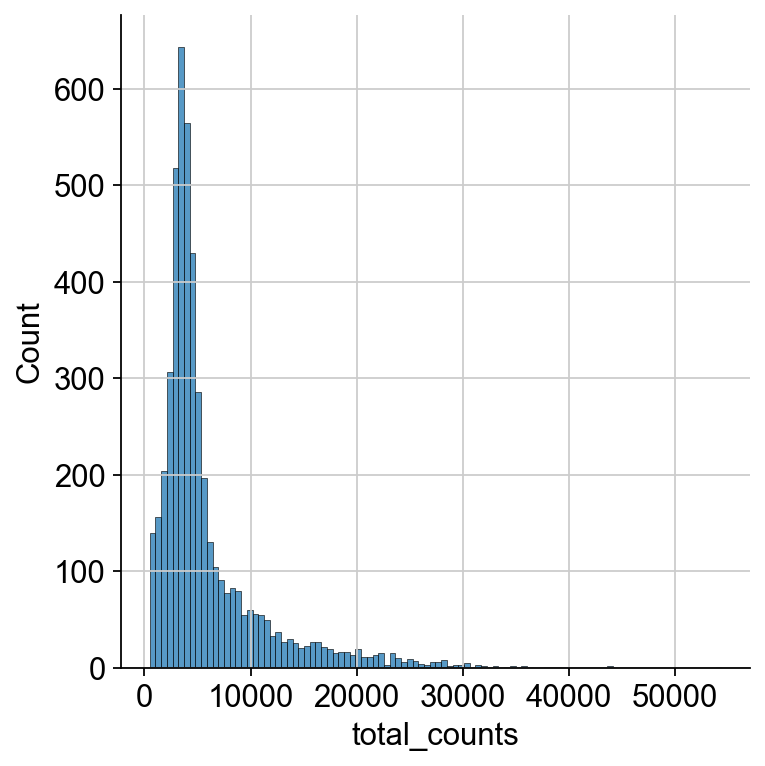

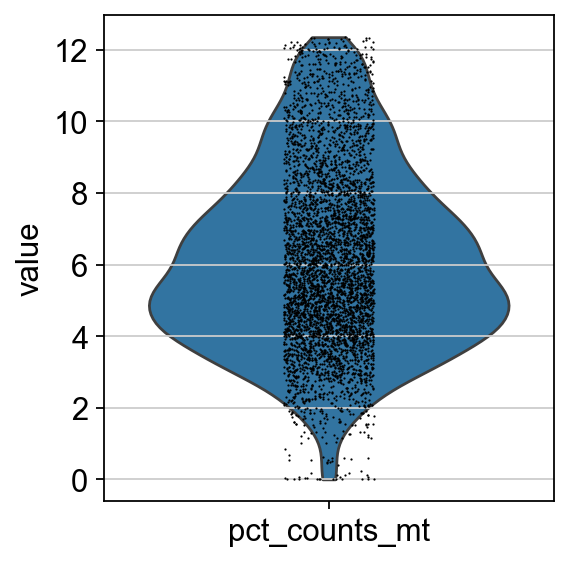

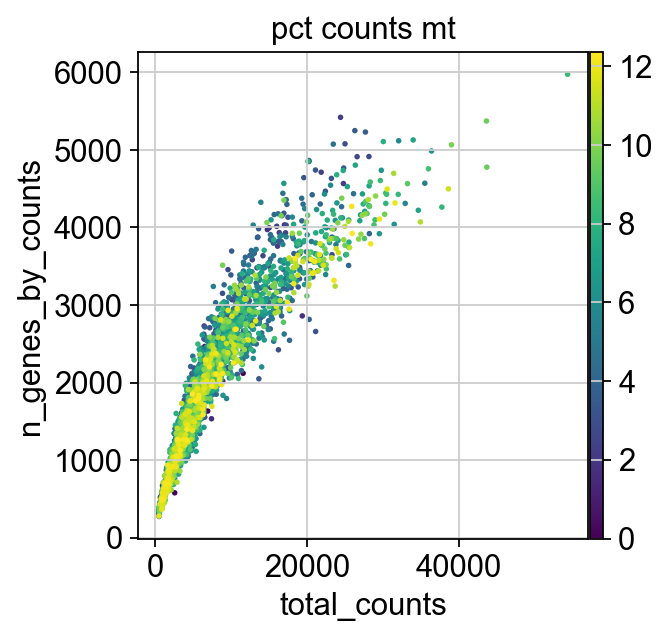

In [7]:
plot1 = sns.displot(adata_CASE.obs["total_counts"], bins=100, kde=False)
plot2 = sc.pl.violin(adata_CASE, "pct_counts_mt")
plot3 = sc.pl.scatter(adata_CASE, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [5]:
#control
adata_CON = sc.read_h5ad('CON_cleaned.h5ad')
adata_CON

AnnData object with n_obs × n_vars = 1890 × 33538
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'doublet'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cells_removed'

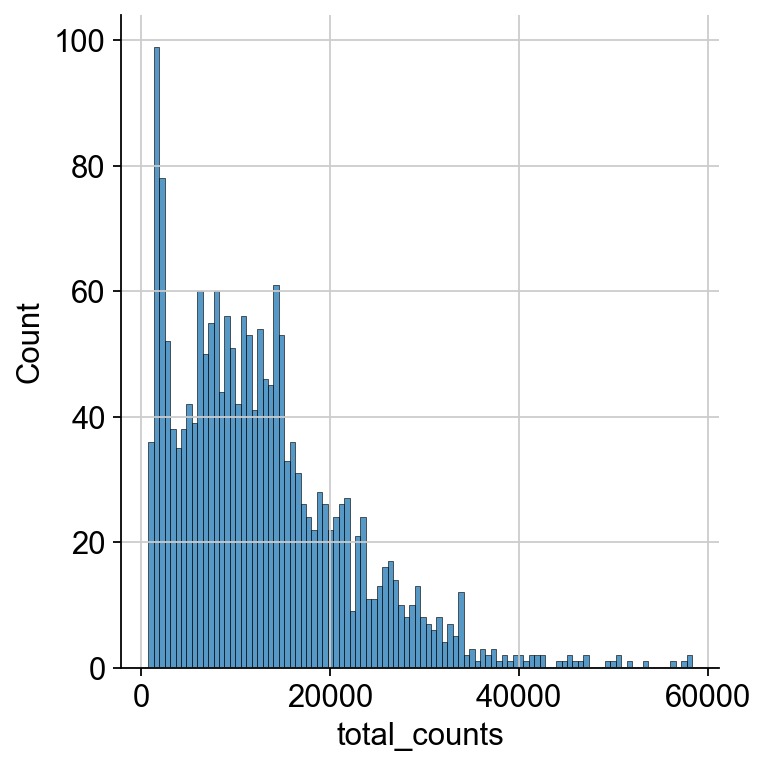

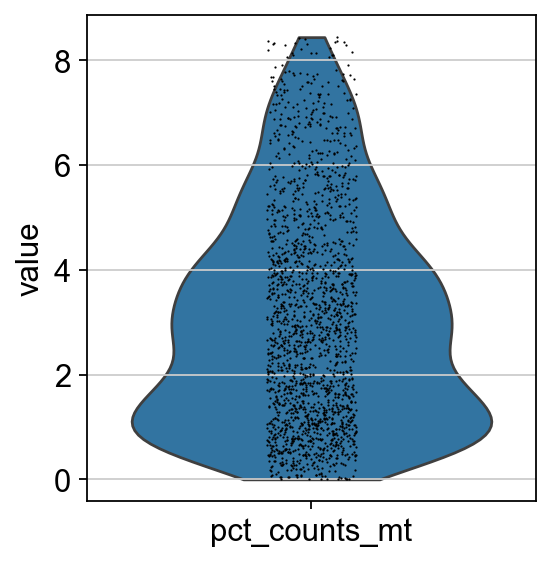

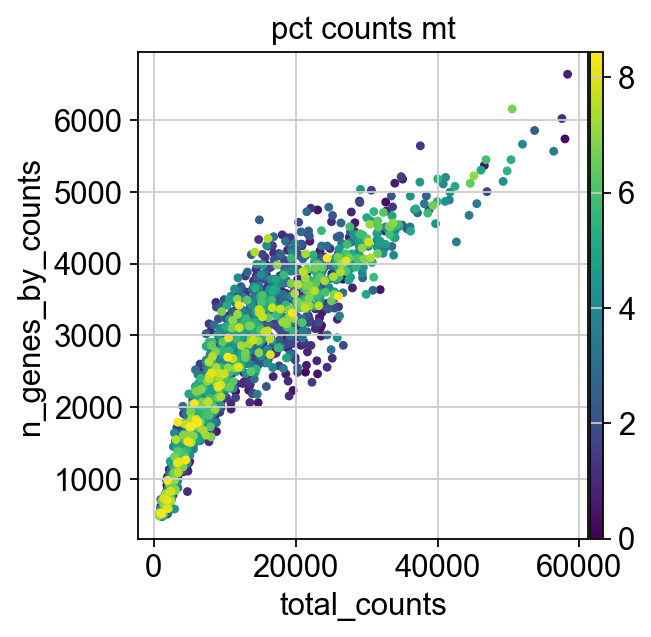

In [8]:
plot1 = sns.displot(adata_CON.obs["total_counts"], bins=100, kde=False)
plot2 = sc.pl.violin(adata_CON, "pct_counts_mt")
plot3 = sc.pl.scatter(adata_CON, "total_counts", "n_genes_by_counts", color="pct_counts_mt")